# Thermal Neural Networks (Tensorflow example)

This jupyter notebook showcases how to utilize a [thermal neural network (TNN)](https://www.sciencedirect.com/science/article/pii/S0952197622005279) on an exemplary data set with the [Tensorflow](https://www.tensorflow.org/) framework.

This example is concise for the sake of comprehensibility, that is, no cross-validation with a validation set is conducted, e.g., for early stopping, no learning rate scheduling, no repeated experiments with different random number generator seeds, etc.

Feel free to build and expand your training pipeline on top of this example.

The data set can be downloaded from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature).
It should be placed in `data/input/`.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

2024-05-26 12:09:44.102760: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 12:09:44.268937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 12:09:44.268969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 12:09:44.296513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 12:09:44.352584: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 12:09:44.353441: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Data setup

In [2]:
path_to_csv = Path().cwd() / "data" / "input" / "measures_v2.csv"
data = pd.read_csv(path_to_csv)
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

temperature_cols = target_cols + ["ambient", "coolant"]
test_profiles = [60, 62, 74]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles]
profile_sizes = data.groupby("profile_id").agg("size")

# normalize
non_temperature_cols = [c for c in data if c not in temperature_cols + ["profile_id"]]
data.loc[:, temperature_cols] /= 200  # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)

# extra feats (FE)
if {"i_d", "i_q", "u_d", "u_q"}.issubset(set(data.columns.tolist())):
    extra_feats = {
        "i_s": lambda x: np.sqrt((x["i_d"] ** 2 + x["i_q"] ** 2)),
        "u_s": lambda x: np.sqrt((x["u_d"] ** 2 + x["u_q"] ** 2)),
    }
data = data.assign(**extra_feats)
input_cols = [c for c in data.columns if c not in target_cols]

In [3]:
# Rearrange features
input_cols = [c for c in data.columns if c not in target_cols + ["profile_id"]]
data = data.loc[:, input_cols + ["profile_id"] + target_cols]


def generate_tensor(profiles_list):
    """Returns profiles of the data set in a coherent 3D tensor with
    time-major shape (T, B, F) where
    T : Maximum profile length
    B : Batch size = Amount of profiles
    F : Amount of input features.

    Also returns a likewise-shaped sample_weights tensor, which zeros out post-padded zeros for use
    in the cost function (i.e., it acts as masking tensor)"""

    tensor = np.full(
        (profile_sizes[profiles_list].max(), len(profiles_list), data.shape[1] - 1),
        np.nan,
    )
    for i, (pid, df) in enumerate(
        data.loc[data.profile_id.isin(profiles_list), :].groupby("profile_id")
    ):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[: len(df), i, :] = df.drop(columns="profile_id").to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = tf.convert_to_tensor(tensor)
    sample_weights = tf.convert_to_tensor(sample_weights)
    return tensor, sample_weights


train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

2024-05-26 12:09:51.895055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 12:09:51.895523: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Model declaration

In [4]:
# working with RNNs in tensorflow:
#  https://www.tensorflow.org/guide/keras/working_with_rnns


class TNNCell(tf.keras.layers.Layer):
    """The main TNN logic. Here, the sub-NNs are initialized as well as the constant learnable
    thermal capacitances. The forward function houses the LPTN ODE discretized with the explicit Euler method
    """

    def __init__(self):
        super().__init__()
        self.sample_time = 0.5  # in s
        self.state_size = len(target_cols)

    def build(self, input_shape):
        # log inverse capacitances
        #   hand-picked init mean, might be application-dependent
        self.caps = self.add_weight(
            shape=(self.state_size,),
            initializer=tf.keras.initializers.RandomNormal(mean=-9.2, stddev=0.5),
        )

        n_temps = len(temperature_cols)  # number of temperatures (targets and input)
        n_conds = int(0.5 * n_temps * (n_temps - 1))  # number of thermal conductances
        # conductance net sub-NN
        self.conductance_net = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(n_conds, activation="sigmoid")]
        )
        # populate adjacency matrix. It is used for indexing the conductance sub-NN output
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        adj_idx_arr = np.ones_like(self.adj_mat)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = tf.convert_to_tensor(
            self.adj_mat[: self.state_size, :], dtype=tf.int64
        )
        self.n_temps = n_temps

        # power loss sub-NN
        self.ploss = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(16, activation="tanh"),
                tf.keras.layers.Dense(self.state_size),
            ],
        )

        self.temp_idcs = [i for i, x in enumerate(input_cols) if x in temperature_cols]
        self.nontemp_idcs = [
            i
            for i, x in enumerate(input_cols)
            if x not in temperature_cols + ["profile_id"]
        ]

    def call(self, input_at_t, states_at_t):
        output_at_t = states_at_t[0]
        temps = tf.concat(
            [output_at_t, tf.gather(input_at_t, self.temp_idcs, axis=-1)], axis=-1
        )
        sub_nn_inp = tf.concat([input_at_t, output_at_t], axis=1)
        conducts = tf.abs(self.conductance_net(sub_nn_inp))
        power_loss = tf.abs(self.ploss(sub_nn_inp))
        heat_transfer_from_temp_diffs = tf.math.reduce_sum(
            (tf.expand_dims(temps, axis=1) - tf.expand_dims(output_at_t, axis=-1))
            * tf.reshape(
                tf.gather(conducts, tf.reshape(self.adj_mat, [-1]), axis=1),
                [conducts.shape[0], self.adj_mat.shape[0], self.adj_mat.shape[1]],
            ),
            axis=-1,
        )
        states_at_t_plus_1 = output_at_t + self.sample_time * tf.exp(self.caps) * (
            heat_transfer_from_temp_diffs + power_loss
        )
        return output_at_t, tf.clip_by_value(states_at_t_plus_1, -1, 5)

## Training

In [9]:
n_epochs = 100
tbptt_size = 512

loss_func = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Nadam(learning_rate=1e-3, clipvalue=1.0)


class TNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.cell = TNNCell()
        self.rec_layer = tf.keras.layers.RNN(
            self.cell, return_sequences=True, time_major=True, return_state=True
        )

    def call(self, inputs, initial_state=None, training=None):
        return self.rec_layer(inputs, initial_state=initial_state, training=training)


model = TNNModel()
model.compile(optimizer=opt, loss=loss_func)


@tf.function
def train_step(x, y, hidden, sample_weights):
    with tf.GradientTape() as tape:
        output, hidden = model(
            x,
            initial_state=(tf.stop_gradient(hidden),),
        )

        loss = loss_func(
            output,
            y,
            sample_weight=sample_weights,
        )
    grads = tape.gradient(loss, model.variables)
    opt.apply_gradients(zip(grads, model.variables))
    return loss, hidden


n_batches = np.ceil(train_tensor.shape[0] / tbptt_size).astype(int)
with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        # first state is ground truth temperature data
        hidden = train_tensor[0, :, -len(target_cols) :]

        # propagate batch-wise through data set
        for i in range(n_batches):
            start, end = i * tbptt_size, (i + 1) * tbptt_size
            loss, hidden = train_step(
                train_tensor[start:end, :, : len(input_cols)],
                train_tensor[start:end, :, -len(target_cols) :],
                hidden,
                train_sample_weights[start:end],
            )

        pbar.update()
        pbar.set_postfix_str(f"loss: {loss:.2e}")

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training: 100%|██████████| 100/100 [12:43<00:00,  7.64s/it, loss: 6.97e-07]


## Testing

In [10]:
# model saving and loading
mdl_path = Path.cwd() / "data" / "models"
mdl_path.mkdir(exist_ok=True, parents=True)
mdl_file_path = mdl_path / "tnn_tf.keras"

model.save(mdl_file_path)  # save
model = tf.keras.models.load_model(  # load
    mdl_file_path, custom_objects={"TNNModel": TNNModel, "TNNCell": TNNCell}
)

In [11]:
# evaluate against test set

@tf.function
def test_step(x, hidden):
    output, hidden = model(
        x,
        initial_state=(hidden,),
    )
    return output


pred = (
    test_step(
        test_tensor[:, :, : len(input_cols)],
        test_tensor[0, :, -len(target_cols) :],
    ).numpy()
    * 200
)

## Visualize Performance
We see the performance for one trial, i.e., one run of random initialized weights.

Usually, running multiple trials with different random number generator seeds yields even better results.

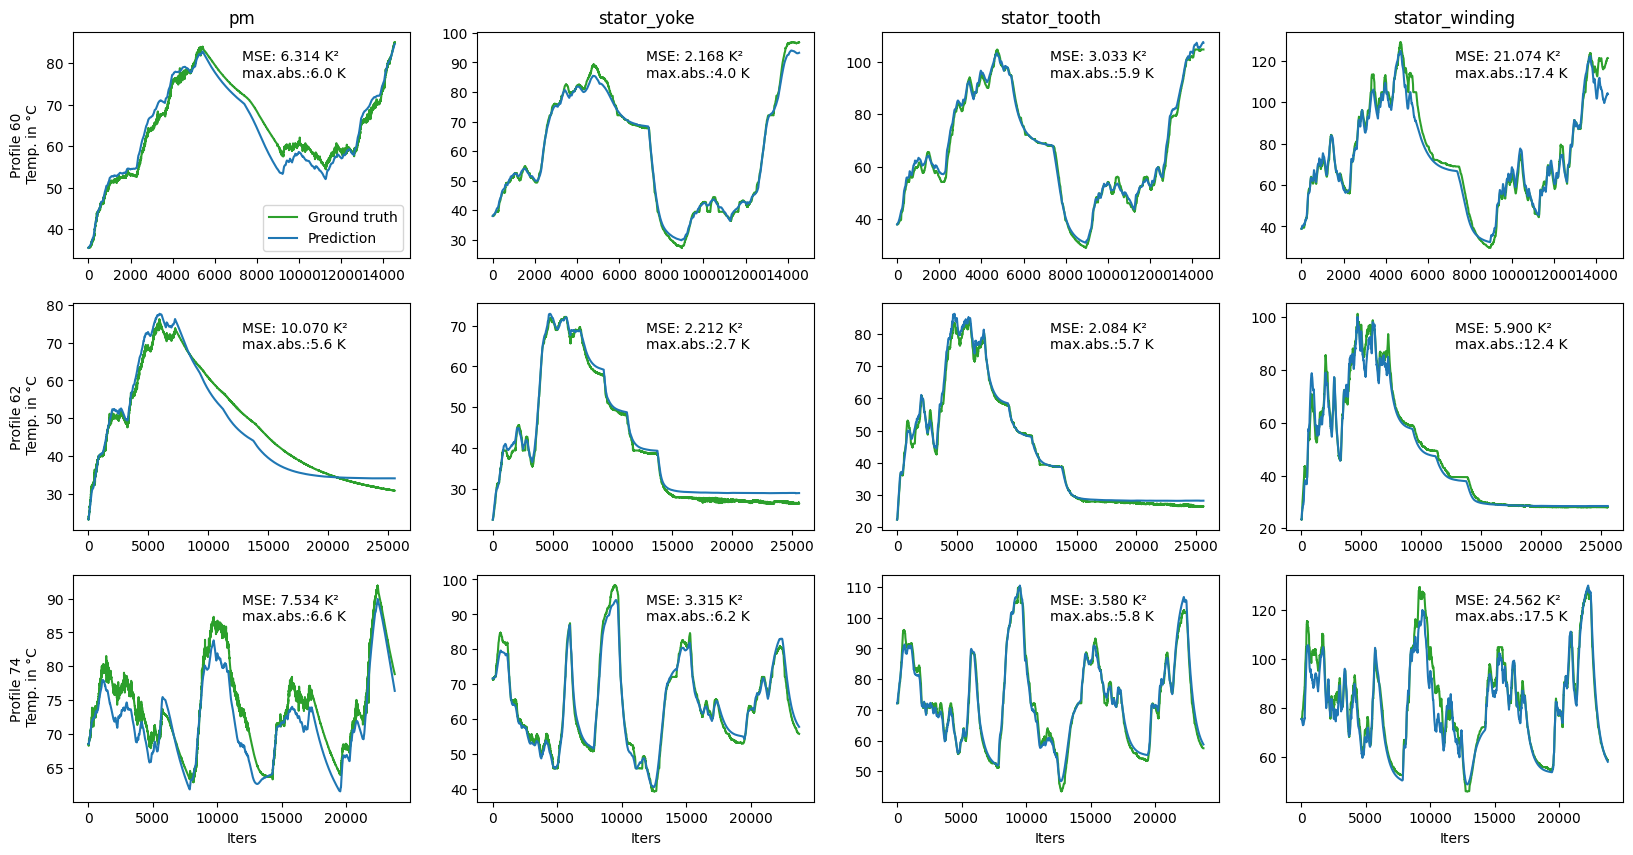

In [12]:
fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(
    data.loc[data.profile_id.isin(test_profiles), target_cols + ["profile_id"]].groupby(
        "profile_id"
    )
):
    y_test *= 200
    profile_pred = pred[: len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(
            y_test.loc[:, col].reset_index(drop=True),
            color="tab:green",
            label="Ground truth",
        )
        ax.plot(profile_pred[:, j], color="tab:blue", label="Prediction")
        ax.text(
            x=0.5,
            y=0.8,
            s=f"MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K",
            transform=ax.transAxes,
        )
        if j == 0:
            ax.set_ylabel(f"Profile {pid}\n Temp. in °C")
            if i == 0:
                ax.legend()
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f"Iters")
        elif i == 0:
            ax.set_title(col)

The performance that is achievable by the hybridization of LPTNs with neural networks is unprecedented and not achievable by pure LPTN or pure black-box ML models.

Note that the visualized performance stems from training a TNN from scratch once. All neural networks are initialized randomly when their training by gradient descent begins.

This means that better performance can be easily achieved by repeating this experiment since the convergence into better local minima becomes likely.

Also consider increasing the number of epochs or decreasing the TBPTT size in order to increase the total number of weight updates, which will further improve accuracy.